# Day Candlestick Color - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-11-04 14:10:00,1890.7,1891.0,1885.5,1887.3,5379
2025-11-04 14:15:00,1887.2,1899.0,1887.2,1898.5,13871
2025-11-04 14:20:00,1898.2,1907.7,1897.0,1904.2,16090


## Prepare data timeframe 5m

In [5]:
data['MA20'] = data['Close'].rolling(20).mean()
data['MA250'] = data['Close'].rolling(250).mean()
data.dropna(inplace=True)

## Tính Volume Profile theo ngày

In [6]:
def volume_profile(df):
    low_price = df["Low"].min()
    high_price = df["High"].max()
    n_bins = 24
    
    # --- Tạo bins ---
    bins = np.linspace(low_price, high_price, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    volume_profile = pd.Series(0.0, index=bin_centers)
    
    # --- Phân bổ volume vào bins ---
    for _, row in df.iterrows():
        # các giá nằm trong khoảng nến
        mask = (bin_centers >= row["Low"]) & (bin_centers <= row["High"])
        count = mask.sum()
        if count > 0:
            vol_per_bin = row["Volume"] / count
            volume_profile.loc[mask] += vol_per_bin

    return volume_profile

def cal_poc(vp):
    poc_price = vp.idxmax()
    return poc_price

def cal_vahl(vp):
    # Tính Value Area (70%)
    sorted_vol = vp.copy().sort_values(ascending=False)
    cum_vol = sorted_vol.cumsum() / sorted_vol.sum()
    value_area_prices = sorted_vol[cum_vol <= 0.7].index
    return  max(value_area_prices), min(value_area_prices)

In [7]:
daily_data = data.resample('D').agg({
        'Volume': 'sum',
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min'
    })
daily_data.dropna(subset=['Close'], inplace=True)

In [8]:
%%time
daily_data["POC"] = 0
daily_data["VAH"] = 0
daily_data["VAL"] = 0
for i, row in daily_data.iterrows():
    current_date = row.name.strftime('%Y-%m-%d ').format()
    # Tạo khoảng thời gian trong ngày
    start_time = pd.Timestamp(current_date + " 08:00:00")
    end_time   = pd.Timestamp(current_date + " 15:00:00")
    
    # Lọc dữ liệu 5m của ngày đó
    tmp_df = data[(data.index >= start_time) & (data.index <= end_time)]
    tmp_vp = volume_profile(tmp_df)
    poc = cal_poc(tmp_vp)
    vah, val = cal_vahl(tmp_vp)
    daily_data.loc[i, 'POC'] = poc
    daily_data.loc[i, 'VAH'] = vah
    daily_data.loc[i, 'VAL'] = val

CPU times: user 32.6 s, sys: 12.9 ms, total: 32.6 s
Wall time: 32.6 s


In [9]:
daily_data

,Volume,Open,Close,High,Low,POC,VAH,VAL
Date,,,,,,,,
2018-08-17,11992,947.7,947.0,949.4,945.0,947.291667,948.575000,946.558333
2018-08-20,88210,946.1,945.0,951.5,942.6,945.752083,950.572917,945.010417
2018-08-21,83718,944.7,958.5,958.5,944.0,946.718750,950.343750,945.510417
2018-08-22,87588,959.5,957.0,960.6,953.6,959.579167,959.870833,956.662500
2018-08-23,84610,957.0,960.6,963.5,955.8,958.847917,962.697917,956.922917
...,...,...,...,...,...,...,...,...
2025-10-29,273188,1943.8,1947.0,1964.7,1936.1,1942.654167,1958.145833,1940.270833
2025-10-30,331492,1947.0,1927.0,1948.4,1910.5,1931.818750,1933.397917,1920.764583
2025-10-31,341853,1928.0,1892.0,1928.0,1887.5,1905.218750,1918.718750,1901.843750


## Data labeling

In [10]:
daily_data["color"] = daily_data.apply(lambda r: "doji" if r["Open"] == r["Close"] else ("green" if  r["Open"] < r["Close"] else "red"), axis=1)
daily_data["next_color"] = daily_data["color"].shift(1)
daily_data.dropna(inplace=True)

Text(0.5, 1.0, "Tỷ lệ Doji / Green / Red của cột 'color'")

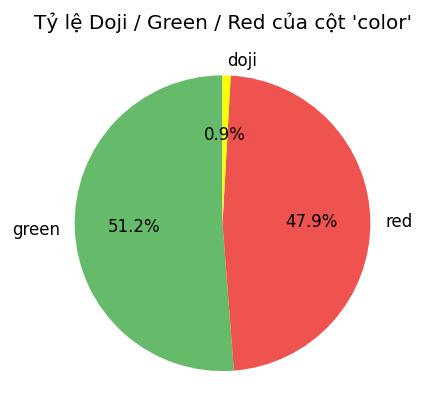

In [11]:
counts = daily_data['color'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(4, 4))
plt.pie(
    counts,
    labels=counts.index.astype(str),
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66bb6a', '#ef5350', 'yellow']
)
plt.title("Tỷ lệ Doji / Green / Red của cột 'color'")

### Close vs VAH & VAL

Text(0.5, 1.0, "Next day's color Distribution by Close & VAH & VAL")

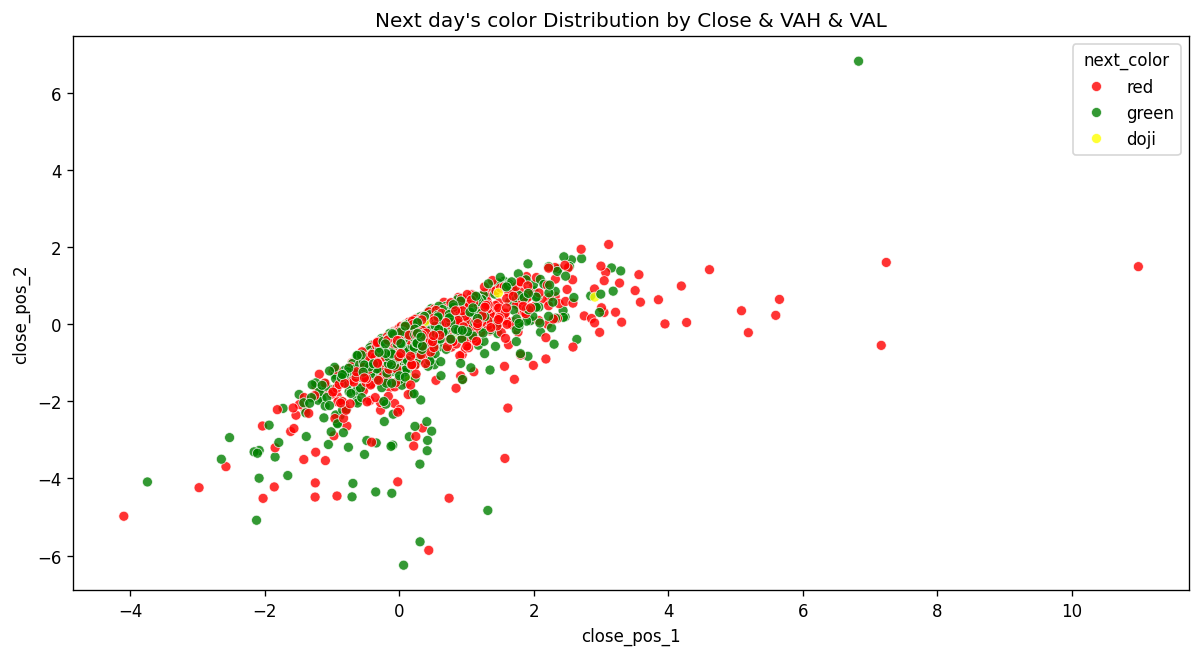

In [12]:
daily_data['close_pos_1'] = (daily_data['Close'] - daily_data['VAL']) * 100 / daily_data['VAL']
daily_data['close_pos_2'] = (daily_data['Close'] - daily_data['VAH']) * 100 / daily_data['VAH']
daily_data.dropna(inplace=True)
sns.scatterplot(
    data=daily_data[['close_pos_1', 'close_pos_2', 'next_color']],
    x='close_pos_1',
    y='close_pos_2',
    hue='next_color',
    palette={'green':'green','red':'red','doji':'yellow'},
    alpha=0.8
)
plt.title("Next day's color Distribution by Close & VAH & VAL")

## next Open vs VAH & VAL

Text(0.5, 1.0, "Next day's color Distribution by next Open & VAH & VAL")

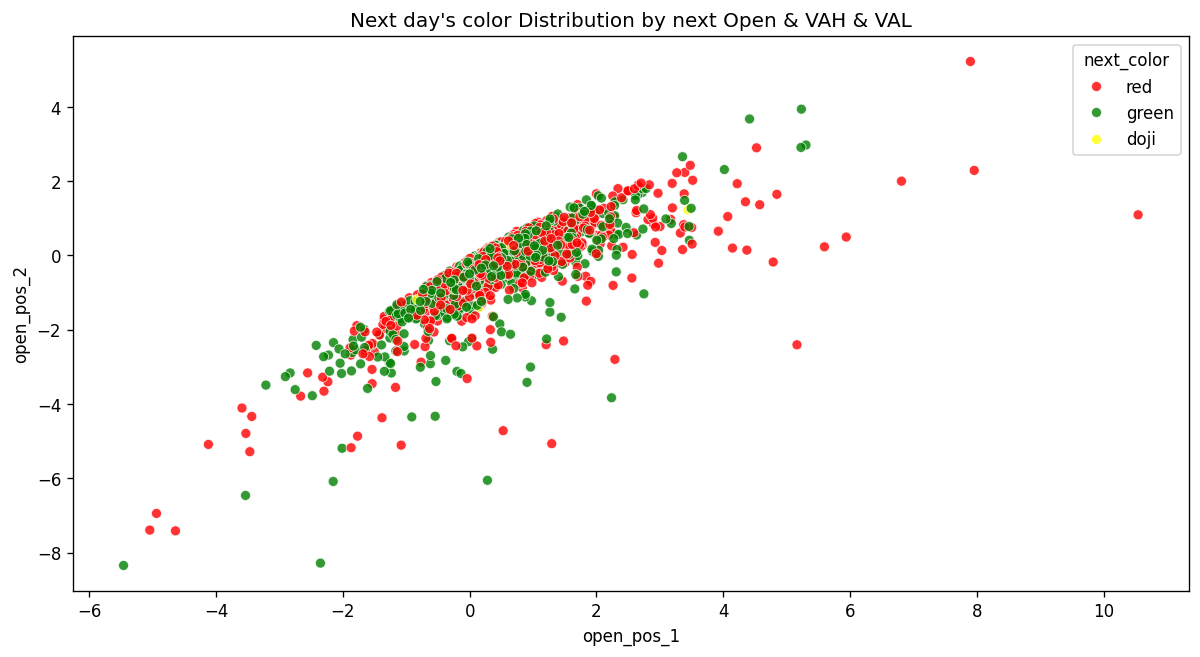

In [13]:
daily_data['next_Open'] = daily_data['Open'].shift(-1)
daily_data['open_pos_1'] = (daily_data['next_Open'] - daily_data['VAL']) * 100 / daily_data['VAL']
daily_data['open_pos_2'] = (daily_data['next_Open'] - daily_data['VAH']) * 100 / daily_data['VAH']
daily_data.dropna(inplace=True)
sns.scatterplot(
    data=daily_data[['open_pos_1', 'open_pos_2', 'next_color']],
    x='open_pos_1',
    y='open_pos_2',
    hue='next_color',
    palette={'green':'green','red':'red','doji':'yellow'},
    alpha=0.8
)
plt.title("Next day's color Distribution by next Open & VAH & VAL")

## next Open vs POC and Close vs POC

Text(0.5, 1.0, "Next day's color Distribution by next Open vs POC and Close vs POC")

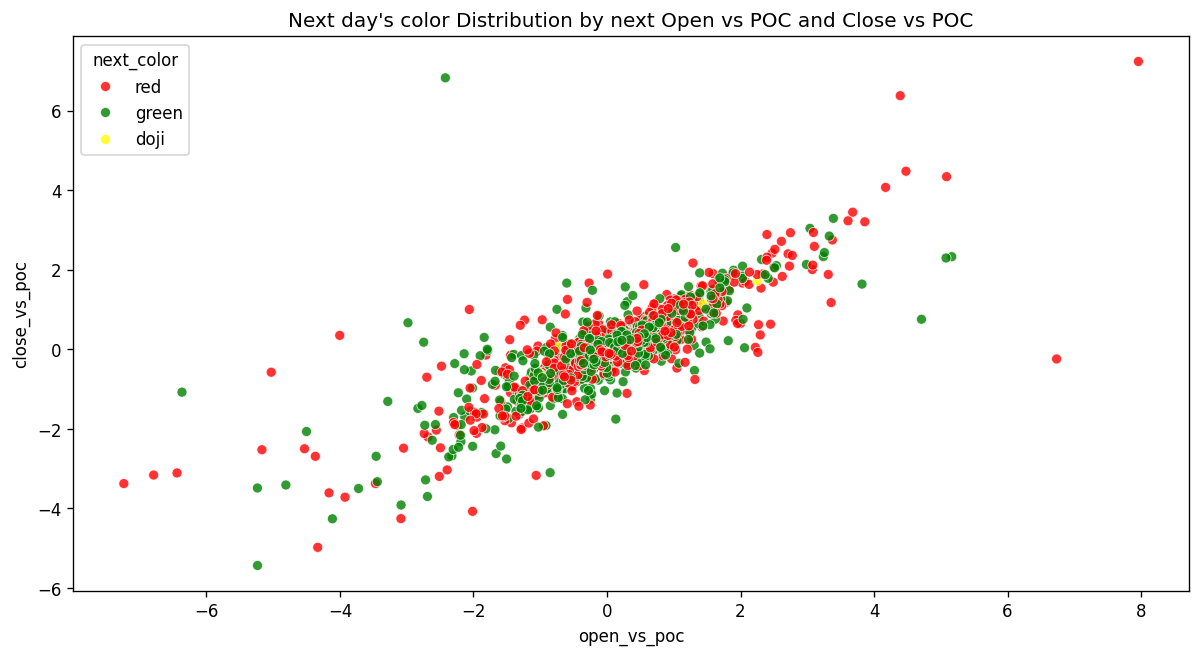

In [14]:
daily_data['open_vs_poc'] = (daily_data['next_Open'] - daily_data['POC']) * 100 / daily_data['POC']
daily_data['close_vs_poc'] = (daily_data['Close'] - daily_data['POC']) * 100 / daily_data['POC']
daily_data.dropna(inplace=True)
sns.scatterplot(
    data=daily_data[['open_vs_poc', 'close_vs_poc', 'next_color']],
    x='open_vs_poc',
    y='close_vs_poc',
    hue='next_color',
    palette={'green':'green','red':'red','doji':'yellow'},
    alpha=0.8
)
plt.title("Next day's color Distribution by next Open vs POC and Close vs POC")